<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP30_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [277]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

,Age,Gender,BMI,DBP,FPG,Chol,Tri,HDL,LDL,ALT,CCR,FFPG
0,26,1,20.1,81,5.8,4.36,0.86,0.90,2.43,12.0,63.8,5.40
1,40,1,17.7,54,4.6,3.70,1.02,1.50,2.04,9.2,70.3,4.10
2,40,2,19.7,53,5.3,5.87,1.29,1.75,3.37,10.1,61.1,4.85


,Age,Gender,BMI,DBP,FPG,Chol,Tri,HDL,LDL,ALT,CCR,FFPG
count,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4302.000000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000
mean,48.085057,1.351615,24.123923,76.360446,5.226368,4.860732,1.588476,1.666765,2.976220,26.754810,71.557080,5.729084
std,14.686155,0.477530,3.397294,11.004056,0.781089,0.925484,1.260003,1.079377,0.892196,22.279922,16.937394,1.424568
min,22.000000,1.000000,15.600000,45.000000,1.780000,1.650000,0.000000,0.000000,0.540000,4.500000,4.860753,3.200000
25%,35.000000,1.000000,21.700000,69.000000,4.700000,4.200000,0.860000,1.130000,2.350000,14.300000,60.000000,4.900000
50%,46.000000,1.000000,24.000000,76.000000,5.140000,4.790000,1.280000,1.340000,2.820000,20.500000,72.000000,5.300000
75%,59.000000,2.000000,26.300000,83.000000,5.700000,5.430000,1.940000,1.610000,3.420000,31.050000,82.300000,6.020000
max,93.000000,2.000000,45.800000,134.000000,6.990000,11.650000,32.640000,4.860753,6.270000,436.200000,307.000000,29.700000


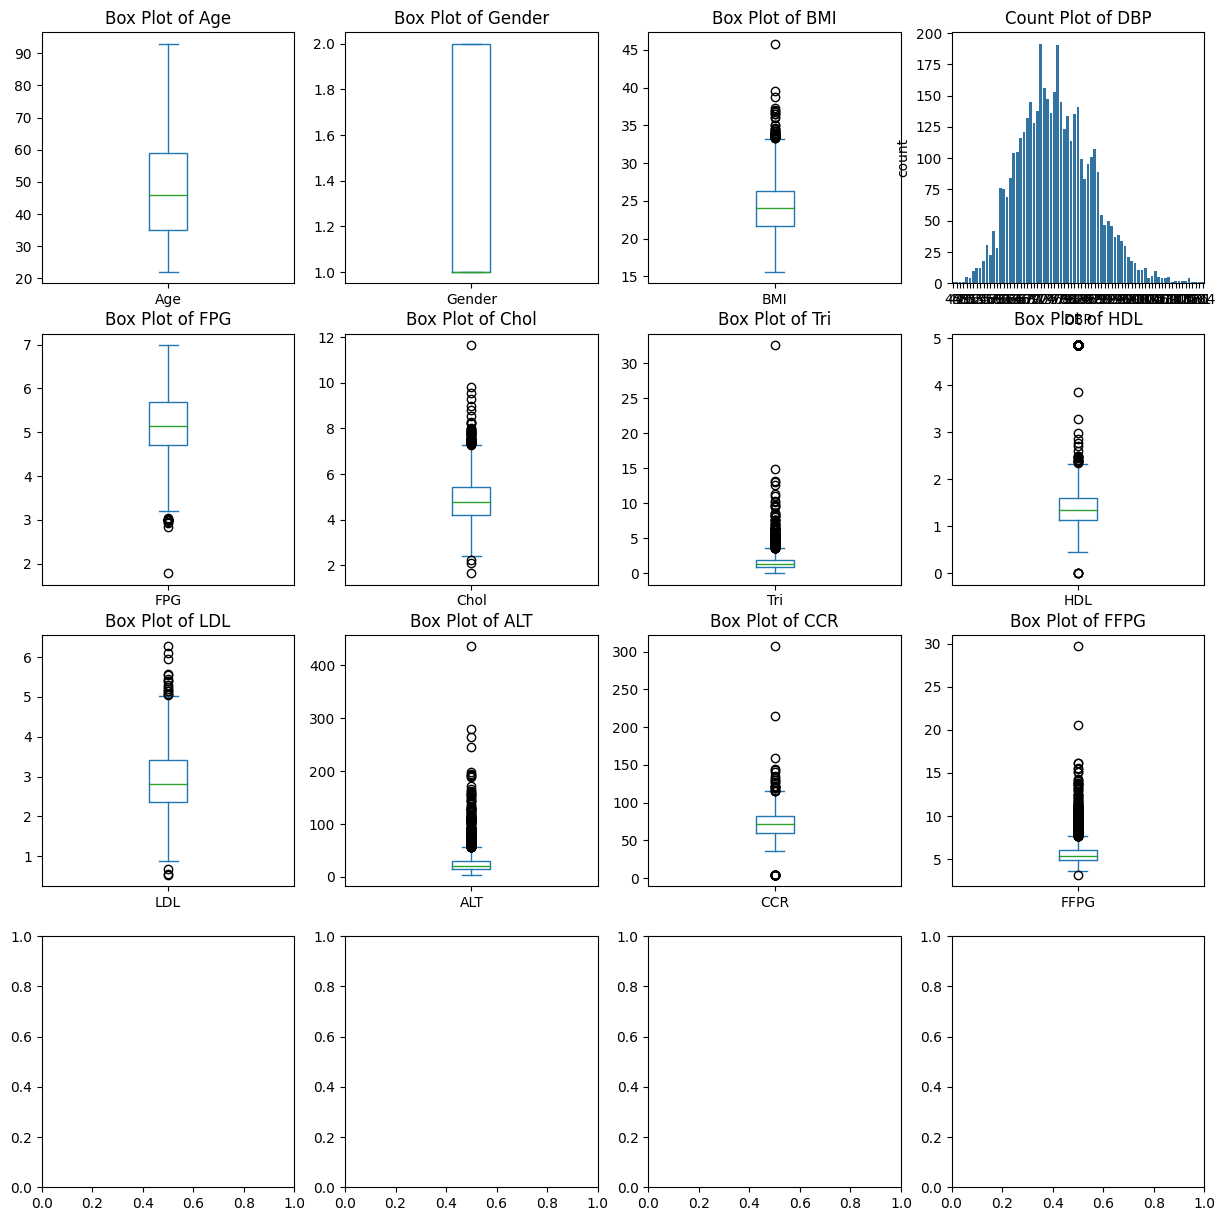

In [278]:
df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p1.csv")

display(df.head(3))
display(df.describe())


target_col = "DBP"
cat_col = ['Gender']
## Differenct 함수 : df.columns.difference 는 안에 내용을 제외한 columns를 보내줌
num_col = list(df.columns.difference([target_col]+ cat_col ))

fig, axes = plt.subplots(4, 4, figsize=(15, 15))  # Adjust figure size as needed
axes = axes.flatten()   # Flatten the 2D array for easier iteration


counter = 0
for col in df.columns :
  if col == target_col or col == cat_col:
    sns.countplot(ax = axes[counter], x = df[col])
    axes[counter].set_title(f"Count Plot of {col}")
    counter += 1

  else :
    df[col].plot(kind = 'box', ax = axes[counter])
    axes[counter].set_title(f"Box Plot of {col}")
    counter += 1

plt.show()



<Axes: >

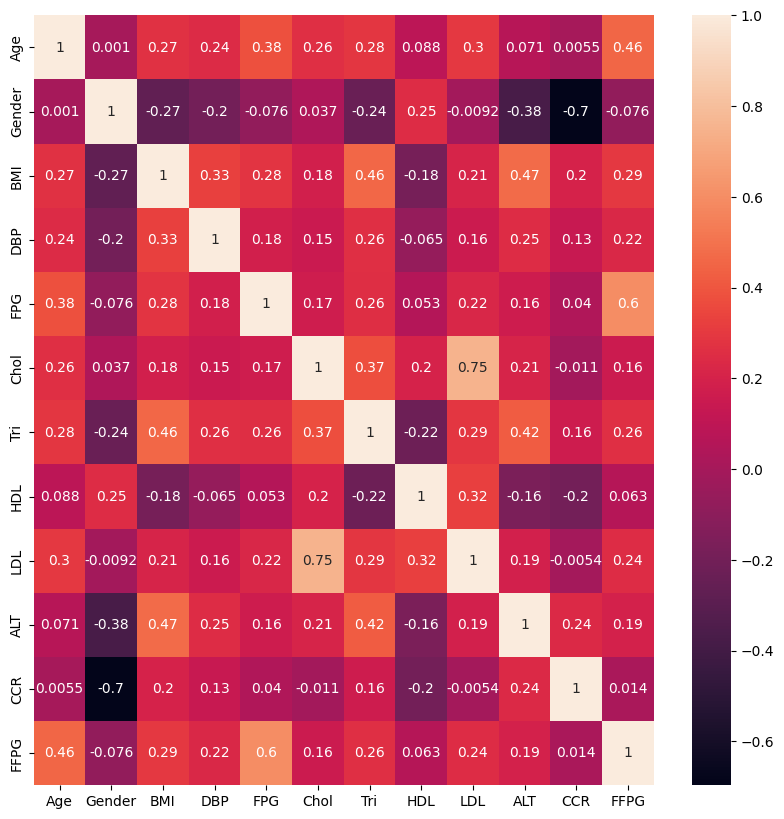

In [279]:
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(method = "spearman"), annot = True)

In [280]:
## 결측 확인
df1 = df.dropna()

독립변수의 차원축소의 필요성을 논하고, 필요에 따라 차원을 축소하고 불필요하다면 그 근거

In [281]:
## 변수간 상관관계 : 변수들간에 강한 상관관계가 있는 경우
# 차원 축소는 - PCA
# 다중공선성 : 독립 변수들간 강한 상관관계가 있는 경우에 발생. 즉, 다중공선성은 차원 축소의 근거가 될 수 있다.
# 차원 축소를 판단하는 통계적 방법인 PCA : 분산이 누적 비율을 살펴보고 주성분 개수를 선택한다.
# VIF :10 이 초과하는 것들은 제거한다.

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor


cols =  df1.columns
remove = 'DBP'
cols = cols[cols != remove]
combined_col = ''

for col in cols :
  combined_col += col + '+'
combined_col = combined_col[:-1]
display(combined_col)


y, X = dmatrices('DBP~'+combined_col, data=df1, return_type='dataframe')

vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(1, len(X.columns))]
vif.index = X.columns[1:]
vif.T

# VIF 다중 공선성이 모두 5보다 작다. 따라서 차원을 축소할 이유가 없다.


'Age+Gender+BMI+FPG+Chol+Tri+HDL+LDL+ALT+CCR+FFPG'

,Age,Gender,BMI,FPG,Chol,Tri,HDL,LDL,ALT,CCR,FFPG
vif,1.340598,1.758522,1.382246,1.426733,2.948522,1.335744,2.697316,4.687216,1.231884,1.614497,1.415785


<Axes: >

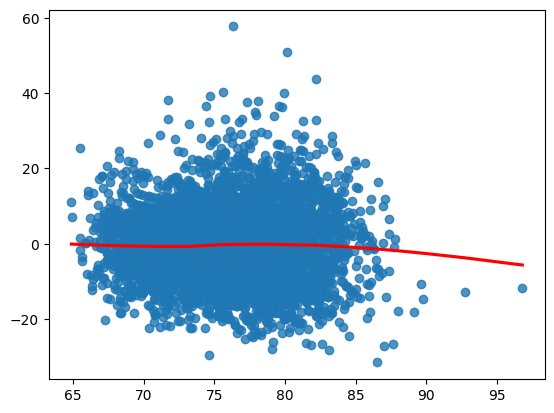

In [282]:
## 등분산성 - 예측과 잔차
from statsmodels.formula.api import ols

model = ols('DBP~' + combined_col, data = df1).fit()
pred = model.predict(df1)

sns.regplot(x = model.predict(df1),
            y = model.resid,
            lowess = True,
            line_kws = {'color' : 'red'})

In [283]:
# Breusch-Pagan test
# 라그랑쥬 계수 검정 - 분산검정
label = ['statistic','p_value','f_value','f p_value']

import statsmodels.stats.api as sms
from statsmodels.compat import lzip

bp_test= sms.het_breuschpagan(model.resid, model.model.exog)

print(dict(zip(label, bp_test)))

# White 검정- 분산검정
white_test = sms.het_white(model.resid, model.model.exog)
print(dict(zip(label, white_test)))

{'statistic': 85.99949770470175, 'p_value': 1.0091313496784433e-13, 'f_value': 7.955360557137903, 'f p_value': 7.304244184317362e-14}
{'statistic': 180.39550197936188, 'p_value': 1.799286056661765e-10, 'f_value': 2.4331703199210453, 'f p_value': 9.390245586856417e-11}


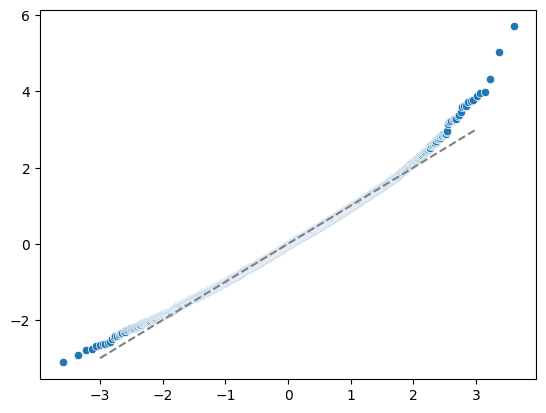

In [284]:
## 정규분포
from scipy import stats
sr = stats.zscore(model.resid)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x =x,y =y)
plt.plot([-3, 3],  [-3, 3], '--', color='grey')


In [285]:
## 정규성
stats.shapiro(model.resid)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    DBP   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     70.69
Date:                Sat, 08 Jun 2024   Prob (F-statistic):          2.69e-146
Time:                        08:20:49   Log-Likelihood:                -16063.
No. Observations:                4302   AIC:                         3.215e+04
Df Residuals:                    4290   BIC:                         3.223e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     53.5600      2.035     26.315      0.0

In [286]:
# 다중공선성 문제가 있는 데이터를 규제가 있는 회귀식으로 과대 적합을 방지하기 위함임으로

# Lasso - 규제 1-norm 몇개의 변수가 0이 되는 경우가 있다.
# Ridge - 규제 2-norm (유클리디안)일부 변수가 0이 될 수 있으나, 라쏘보다는 가능성이 희박하다
# Elastic NET- 라쏘와 릿지의 중간

In [287]:
from sklearn.model_selection import train_test_split

x =df1.drop(columns = 'DBP', axis = 1)
y = df1.DBP

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1234)

In [288]:
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

lasso_pipeline = Pipeline([("scaler", RobustScaler()),
                           ("Lasso", Lasso())])

lasso_params = {'Lasso__alpha': np.logspace(-8, 8, 100)}

lasso_pipeline = GridSearchCV(lasso_pipeline, lasso_params, scoring = 'neg_root_mean_squared_error')

lasso_pipeline.fit(x_train, y_train)
print(lasso_pipeline.best_params_)
print(lasso_pipeline.best_score_)

{'Lasso__alpha': 0.061359072734131756}
-10.188042756831626


In [289]:

ridge_pipeline = Pipeline([( "scaler" , RobustScaler()),
                       ("Ridge", Ridge())
                   ])

from sklearn.model_selection import GridSearchCV
ridge_params = {'Ridge__alpha': np.logspace(-8, 8, 100)}

# initialize
Ridge_pipeline = GridSearchCV(ridge_pipeline, ridge_params, scoring ='neg_root_mean_squared_error')

# fit
Ridge_pipeline.fit(x_train,y_train)
print(Ridge_pipeline.best_params_)
print(Ridge_pipeline.best_score_)

{'Ridge__alpha': 49.770235643321136}
-10.19351723464437


In [290]:
enet_pipeline = Pipeline([( "scaler" , RobustScaler()),
                       ("ElasticNet", ElasticNet())
                   ])

from sklearn.model_selection import GridSearchCV
ElasticNet_params = {'ElasticNet__alpha': np.logspace(-8, 8, 100)}

Ela_pipeline = GridSearchCV(enet_pipeline, ElasticNet_params, scoring = 'neg_root_mean_squared_error')
Ela_pipeline.fit(x_train, y_train)
print(Ela_pipeline.best_params_)
print(Ela_pipeline.best_score_)

{'ElasticNet__alpha': 0.04229242874389508}
-10.191105759875136


가장 성능 좋은 알고리즘을 이용하여 K-Fold 교차검증

In [291]:
from sklearn.model_selection import KFold

from sklearn.model_selection import KFold

scaler = RobustScaler()
x_scaled = scaler.fit_transform(x_train)
xt_scaled = scaler.fit_transform(x_test)
lasso_params = {'alpha': np.logspace(-8, 8, 100)}

kf = KFold(n_splits=10, random_state=1, shuffle=True)
lasso_pipeline = GridSearchCV(Lasso(), lasso_params, scoring ='neg_root_mean_squared_error', cv=kf).fit(x_scaled, y_train)

print('Best parameters:', lasso_pipeline.best_params_)
print('Best score:', -lasso_pipeline.best_score_)

Best parameters: {'alpha': 0.006579332246575682}
Best score: 10.170818030723312


In [292]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p2_v2.csv')
df.head()

,사고년도,가해자성별,가해자연령,가해차종,가해자신체상해정도,피해자성별,피해자연령,피해차종,피해자신체상해정도,사고유형,가해자법규위반,기상상태,시각,사건번호
0,2015,남,46세,승합차,상해없음,여,64세,자전거,경상,차대차 - 기타,안전운전불이행,맑음,2015-07-03_10시,ID_796
1,2019,남,53세,승용차,상해없음,여,57세,자전거,경상,차대차 - 후진중충돌,안전운전불이행,맑음,2019-10-12_10시,ID_6697
2,2015,남,39세,승용차,상해없음,남,63세,자전거,중상,차대차 - 기타,기타,맑음,2015-03-23_20시,ID_919
3,2016,남,12세,자전거,상해없음,남,52세,보행자,경상,차대사람 - 길가장자리구역통행중,안전운전불이행,맑음,2016-04-10_15시,ID_2512
4,2015,남,54세,승용차,상해없음,남,63세,자전거,중상,차대차 - 기타,안전운전불이행,맑음,2015-08-04_6시,ID_75


In [293]:
for col in df.columns[:-1] :
  print(col)
  a = str(col)
  print(df[a].unique())


사고년도
[2015 2019 2016 2017 2018 2020]
가해자성별
['남' '여']
가해자연령
['46세' '53세' '39세' '12세' '54세' '69세' '56세' '51세' '61세' '48세' '49세' '40세'
 '44세' '17세' '50세' '43세' '27세' '31세' '22세' '63세' '70세' '38세' '74세' '57세'
 '42세' '59세' '67세' '19세' '55세' '35세' '45세' '30세' '28세' '20세' '82세' '37세'
 '68세' '41세' '15세' '34세' '47세' '33세' '65세' '36세' '60세' '66세' '58세' '71세'
 '29세' '52세' '72세' '25세' '81세' '10세' '32세' '26세' '64세' '77세' '75세' '62세'
 '73세' '18세' '13세' '23세' '24세' '16세' '불명' '11세' '7세' '78세' '85세' '79세'
 '14세' '21세' '76세' '9세' '83세' '89세' '80세' '86세' '88세' '8세' '84세' '91세'
 '94세']
가해차종
['승합차' '승용차' '자전거' '화물차' '이륜차' '건설기계' '원동기장치자전거' '불명' '농기계' '기타'
 '개인형이동수단(PM)' '사륜오토바이(ATV)' '특수차']
가해자신체상해정도
['상해없음' '부상신고' '경상' '기타불명']
피해자성별
['여' '남']
피해자연령
['64세' '57세' '63세' '52세' '71세' '12세' '61세' '72세' '49세' '18세' '24세' '54세'
 '46세' '27세' '14세' '70세' '15세' '65세' '59세' '62세' '34세' '22세' '47세' '25세'
 '78세' '68세' '82세' '11세' '36세' '48세' '77세' '67세' '19세' '26세' '10세' '60세'
 '31세' '21세' '8세' '51세' '40세' '9세' '58세' 

In [294]:
df1 = df[(df.가해자연령 != '불명') & (df.가해자신체상해정도 != '기타불명') ]

# 전처리
df1['가해자연령'] = df1.가해자연령.str.split('세').str[0].astype(int)
df1['피해자연령'] = df1.피해자연령.str.split('세').str[0].astype(int)

df1['시각'] = df1['시각'].astype(str)
df1['시각'] = pd.to_datetime(df1['시각'],format="%Y-%m-%d_%H시")

df2 = df1.drop(['사건번호'], axis = 1)

In [295]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7598 entries, 0 to 7825
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   사고년도       7598 non-null   int64         
 1   가해자성별      7598 non-null   object        
 2   가해자연령      7598 non-null   int64         
 3   가해차종       7598 non-null   object        
 4   가해자신체상해정도  7598 non-null   object        
 5   피해자성별      7598 non-null   object        
 6   피해자연령      7598 non-null   int64         
 7   피해차종       7598 non-null   object        
 8   피해자신체상해정도  7598 non-null   object        
 9   사고유형       7598 non-null   object        
 10  가해자법규위반    7598 non-null   object        
 11  기상상태       7598 non-null   object        
 12  시각         7598 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(9)
memory usage: 831.0+ KB


In [296]:
## 주말여부 만들기

from datetime import datetime
df2.head(3)
df2['주말여부'] = df2['시각'].dt.dayofweek.map(lambda x : '주말' if x >= 5  else '평일')

In [297]:
## 피해자 신체상해정도에 따른 독립 변수들의 유의한지

df2['피해자신체상해정도'].unique()  # 경상, 중상

target = '피해자신체상해정도'
df2.columns.difference([target])



Index(['가해자법규위반', '가해자성별', '가해자신체상해정도', '가해자연령', '가해차종', '기상상태', '사고년도',
       '사고유형', '시각', '주말여부', '피해자성별', '피해자연령', '피해차종'],
      dtype='object')

In [298]:
from sklearn.preprocessing import LabelEncoder

df3 = df2.copy()

for col in df3.select_dtypes(include = 'object').columns.difference(['피해자신체상해정도']) :
  le = LabelEncoder()
  df3[col] = le.fit_transform(df3[col])

target = '피해자신체상해정도'
num_col = ['가해자연령','피해자연령']

cat_list =  df3.columns.difference([target] + num_col + ['사고년도','시각'])
num_list = df3[num_col].columns



In [299]:
from scipy.stats import ttest_ind
n_lst = []
for col in df3.columns:
  for k in num_col :
      if col == k :
        group1 = df3[df3['피해자신체상해정도'] == '경상'][k]
        group2 = df3[df3['피해자신체상해정도'] == '중상'][k]

        stat , p_val = ttest_ind(group1, group2)
        n_lst.append([k, p_val])

n_pd = pd.DataFrame(n_lst, columns = ['var','p_val'])

In [300]:
c_lst = []
for col in cat_list:
  cross = pd.crosstab(df3[col], df3['피해자신체상해정도'])
  chi2, p_val, df, ex = stats.chi2_contingency(cross)
  c_lst.append([col, p_val])

c_pd = pd.DataFrame(c_lst, columns = ['var','p_val'])

In [301]:
valid_df = pd.concat([n_pd, c_pd], axis = 0)
valid_df['check'] = valid_df.p_val.map(lambda x  :'유의'  if x < 0.05 else '유의하지않음')
print(valid_df)



         var         p_val   check
0      가해자연령  8.240408e-01  유의하지않음
1      피해자연령  3.536123e-78      유의
0    가해자법규위반  1.008550e-02      유의
1      가해자성별  4.160249e-01  유의하지않음
2  가해자신체상해정도  4.044886e-02      유의
3       가해차종  7.504531e-05      유의
4       기상상태  3.602292e-01  유의하지않음
5       사고유형  1.471423e-02      유의
6       주말여부  8.110976e-01  유의하지않음
7      피해자성별  1.714813e-05      유의
8       피해차종  1.131041e-03      유의


In [302]:
pass_cols = list(valid_df[valid_df['check'] == '유의']['var'].values)

In [303]:
X = df3[pass_cols]
y = df3['피해자신체상해정도']

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 34)
s_x, s_y = smote.fit_resample(X, y)
#print(s_x.shape)
#print(s_y.shape)

merge_df = pd.concat([X, s_x])
merge_df.head(3)

merge_num_col = ['피해자연령']
merge_cat_col = merge_df.columns.difference(merge_num_col)


for cols in merge_df.columns:
  if cols ==  '피해자연령' :
    print(f"{col}은 연속형 변수로 평균은 {merge_df[cols].mean()} 이다")

  else :
    count_df = merge_df[cols].astype(str).value_counts()
    print(count_df)



피해차종은 연속형 변수로 평균은 48.16826692270763 이다
가해자법규위반
9     10714
7      2635
3      1150
1       617
2       420
8       305
10      292
11      247
5       198
6        49
4        21
12       14
0         2
Name: count, dtype: int64
가해자신체상해정도
2    15972
0      421
1      271
Name: count, dtype: int64
가해차종
5     10419
9      2889
11     1542
8       768
6       684
7       245
1        49
10       38
0        13
2         9
4         6
3         2
Name: count, dtype: int64
사고유형
5     4768
11    4589
10    3845
6      948
0      605
4      513
9      494
2      340
7      307
3       91
1       68
8       49
12      47
Name: count, dtype: int64
피해자성별
0    11488
1     5176
Name: count, dtype: int64
피해차종
6    14704
2     1614
5      230
3       59
4       51
7        2
1        2
0        2
Name: count, dtype: int64


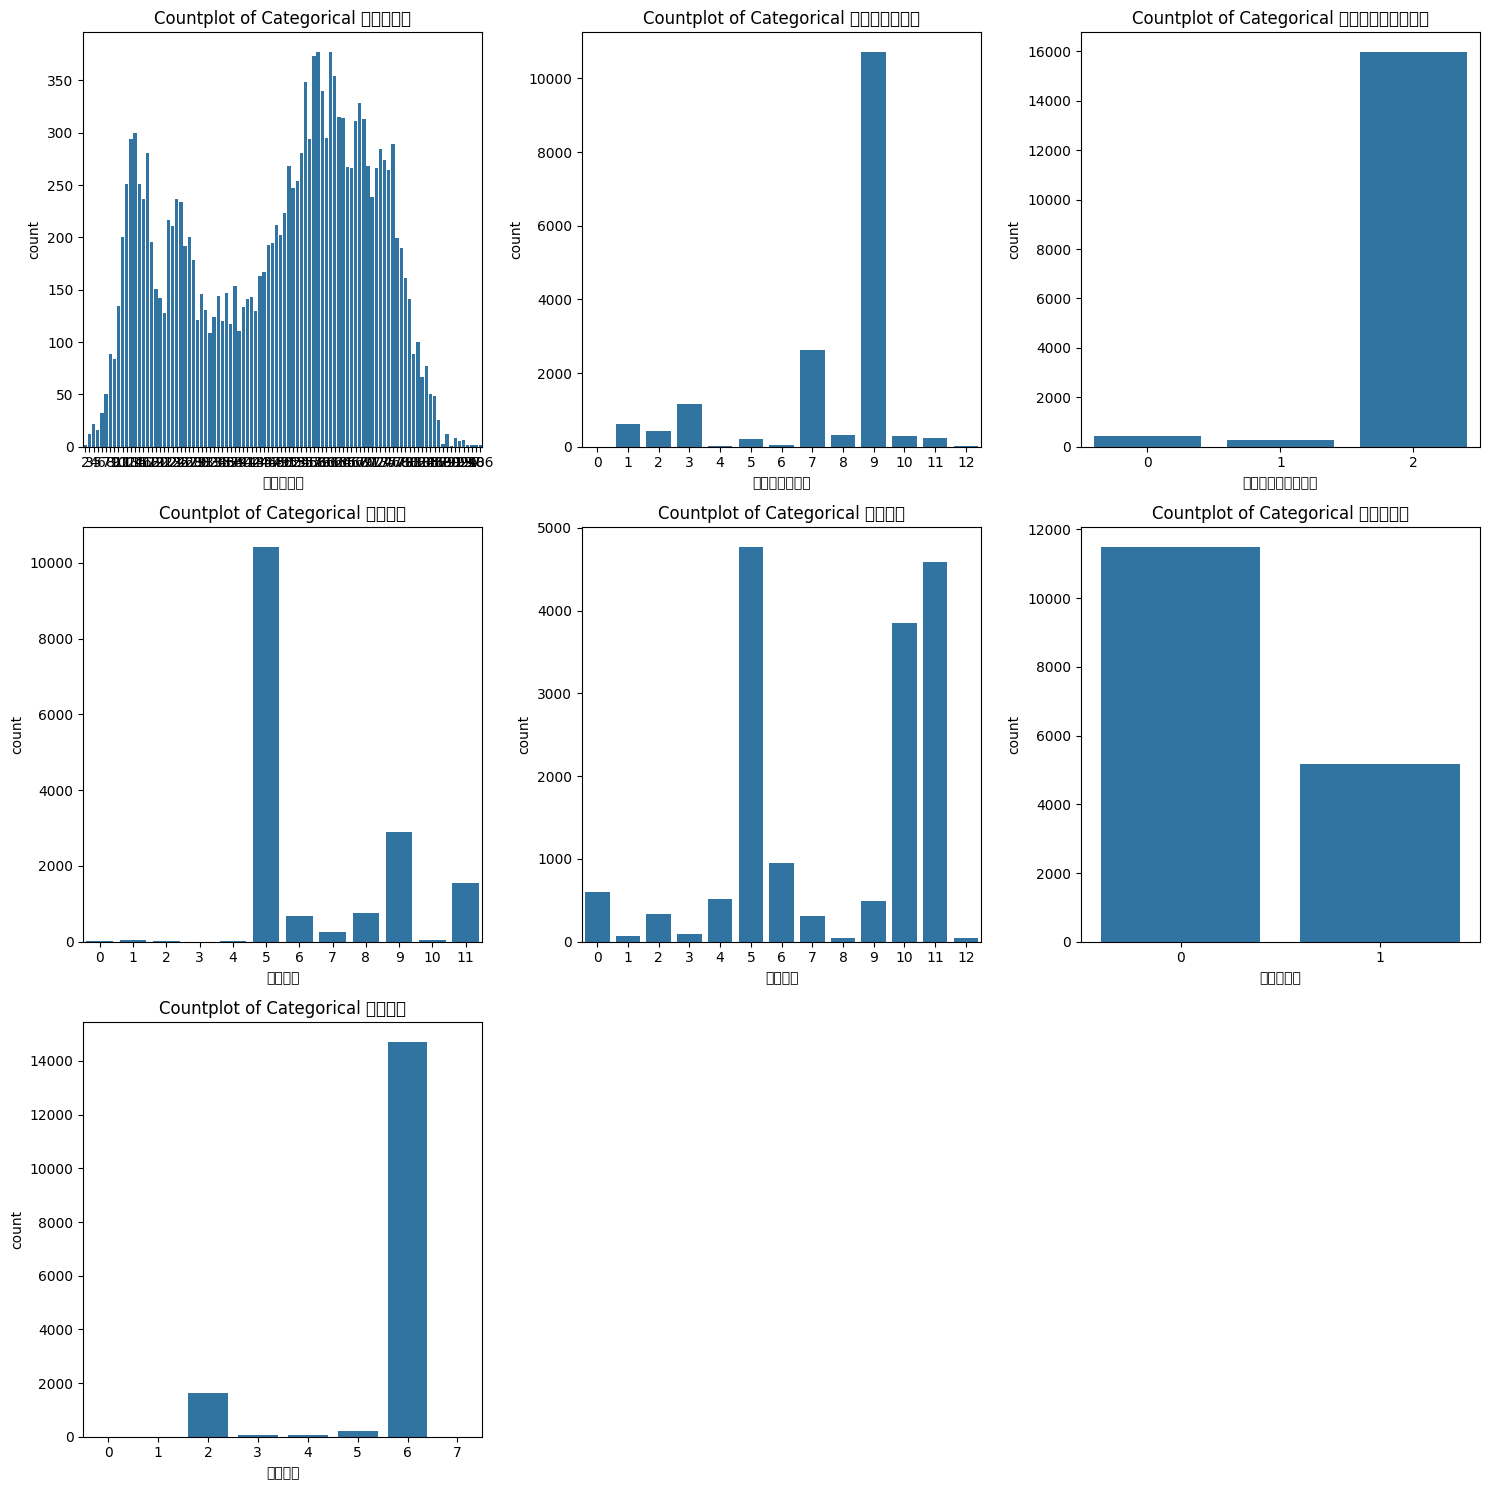

In [304]:
import warnings

# 경고를 무시하고 싶은 경고 메시지의 종류와 동작을 설정합니다.
warnings.filterwarnings('ignore', category=Warning)


fig, axes = plt.subplots(3,3, figsize = (15,15))
axes = axes.flatten()

counter = 0
for cols in merge_df.columns:
  if cols ==  merge_num_col :
     sns.histplot(merge_df[cols])
     plt.axvline(merge_df[cols].mean(), color = 'red', label =   {merge_df[cols].mean()})
     axes[counter].set_title(f"HIstogram of Numeric {cols}")
     counter += 1

  else :
    sns.countplot(ax = axes[counter], x = merge_df[cols])
    axes[counter].set_title(f"Countplot of Categorical {cols}")
    counter += 1

## 안 나오게 하기
for i in range(counter, len(axes)):
  axes[i].set_visible(False)

plt.tight_layout()
plt.show()


0.6055147058823529
0.6273011462313303
0.6051470588235294
0.6169757489300998


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

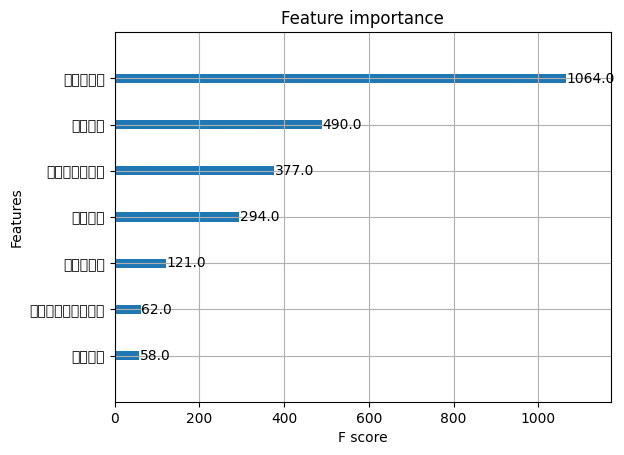

In [305]:
## 피해자 신체상해정도를 종속변수로 로지스틱 회귀, XGB 분류 모델 및 성능 비교하기

from sklearn.linear_model import LogisticRegression
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

label_y = le.fit_transform(s_y)

# 1) split data
x_train, x_test, y_train, y_test= train_test_split(s_x, label_y, test_size = 0.3, random_state = 1234)

# 1) Logisitc
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
print(accuracy_score(lr_pred, y_test))
print(f1_score(y_test, lr_pred))


# 2) xgb
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_test)
print(accuracy_score(xgb_pred, y_test))
print(f1_score(y_test, xgb_pred))


xgboost.plot_importance(xgb)